# Exploratory Data Analysis

Following our path in this competition we will begin our journey by doing an extensive exploratory data analysis to get a deeper knowledge of our dataset. So here I want to explore anything related to the endogenous variable (unit sales), exogenous variables (price and date) as well as characteristics intrinsic to the hierarchical structure of the data, that is, is our sales history trough the same state have different patterns for different stores? Department? How can we use this extra structure information to help us in our analysis? I hope to answer this kind of question in this notebook.

## Importing Data and Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import sys
import os
import gc

sys.path.append("../src")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import cufflinks as cf

cf.go_offline()

import pmdarima as pm

#### You can skip this part

In [3]:
# df_sales = pd.read_csv("../data/raw/sales_train_validation.csv")
# df_sales.shape

In [4]:
# df_sales.head(5)

In [5]:
# df_calendar = pd.read_csv("../data/raw/calendar.csv", parse_dates=["date"])
# df_calendar.head(5)

## Transforming data into Tidy Format

From the excellent [post created by Tom Augspurger](https://tomaugspurger.github.io/modern-5-tidy), we could transform our data into a tidy format so we can easily perform standard calculations, as well as plotting the desired graphs. In summary, a tidy data is the one which:
 - Each variable forms a column
 - Each observation forms a row
 - Each type of observational unit forms a table
 
Clearly our sales data does not come in a tidy format, since we have many observation in a single row. We define an observation by being the unit sales sold for a specific item in a day. Let's do that.

In [6]:
# df_sales_melted = (df_sales.melt(id_vars=["id", "item_id", "dept_id", "store_id", "state_id", "cat_id"],
#                                     var_name="d",
#                                     value_name="unit_solds")
#                             .assign(simple_trend=lambda df: df["d"].str.extract(r"(\d+)").astype(int))
#                     )

In [7]:
# df_sales_melted.shape

Let's merge now with calendar dataset so we are able to start our analysis.

In [8]:
# df_sales_cal = (df_sales_melted.merge(df_calendar,
#                                         on="d",
#                                         how="left"))
# df_sales_cal.shape

In [9]:
# del df_sales_melted
# gc.collect()

In [10]:
# Saving data to feather store for later reuse
# df_sales_cal.to_feather('../data/preprocessed/df_sales_cal.feather')

## Top-Down Overview

Let's create visualizations by starting from top aggregations and exploration all over to the lower levels. Later, we do the same but using this time price variables.

### Overall sales by Walmart - M5 data

In [3]:
df_sales_cal = pd.read_feather('../data/preprocessed/df_sales_cal.feather')
df_sales_cal.shape

(58327370, 22)

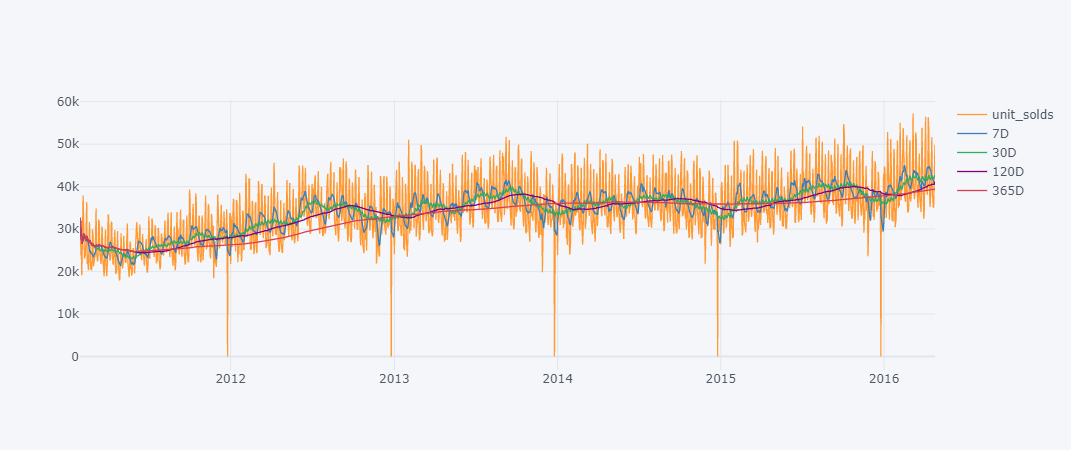

In [4]:
df_total_sales_grp = df_sales_cal.groupby("date")["unit_solds"]

moving_averages = ["7D", "30D", "120D", "365D"]

df_total_agg_sales = df_total_sales_grp.sum().to_frame(name='unit_solds')
for moving_average in moving_averages:
    df_total_agg_sales[moving_average] =  df_total_sales_grp.sum().rolling(moving_average).mean()
    
df_total_agg_sales.iplot()

This is the total aggregated series in our dataset, meaning that we summed over all stores, departments and products to produce what would be total sales of Walmart M5 dataset in a daily basis. Also, we plotted the moving averages for 7D, 30D, 120D abd 356D to capture tendency over time. It is interesting how weekly moving averages captures monthly cycles really well. So we are likely to have multiple seasonalities inside the same time series, to be honest, I expected that since we have a variety of products and they can have multiple sales patterns.

Some things to point out:
 - There is a small increase in sales, captured by 365D MA line. This is not s significant trend, but we should be aware of it and treat properly when doing modelling.
 - Strong seasonality as stated above. We will explore it further and try to capture more insights when plotting data by state, departments, stores, etc.
 - Clearly we have outliers in December 25. This happens because all stores close in this specific holiday.
 - There seems not be a cycle.
 - The series' variance has experienced a slightly increasing in the long period, maybe creating a standard deviation rolling plot.
 - No abrupt changes in the process generation of the data.
 
Before going to lower levels of the hierarchy, let's explore more about what we discussed, to begin with variance plot over time. 

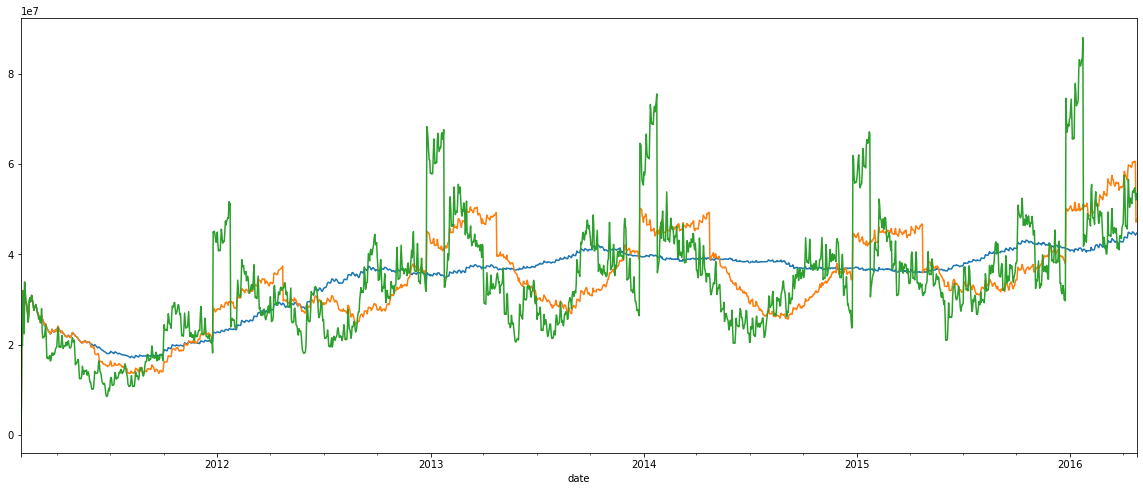

In [5]:
fig, ax = plt.subplots(figsize=(20, 8))

df_total_agg_sales["unit_solds"].rolling("365D").var().plot(ax=ax)
df_total_agg_sales["unit_solds"].rolling("120D").var().plot(ax=ax)
df_total_agg_sales["unit_solds"].rolling("30D").var().plot(ax=ax)

Hmmm, the long-run variance does not increase too much in the total series.

#### Distribution of sales by week and month

In [16]:
df_total_agg_sales["month"] = df_total_agg_sales.index.month
df_total_agg_sales["week"] = df_total_agg_sales.index.week
df_total_agg_sales["weekday"] = df_total_agg_sales.index.weekday

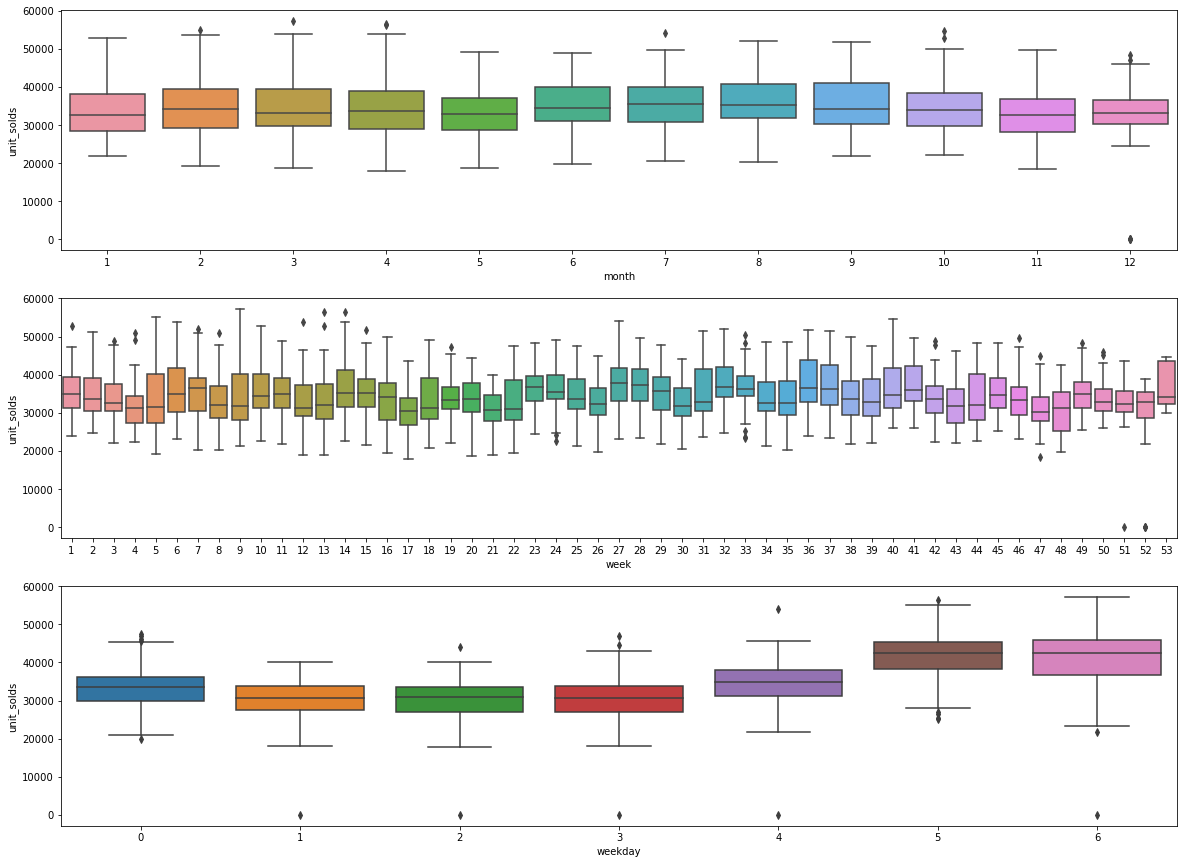

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

sns.boxplot(x="month", y="unit_solds", data=df_total_agg_sales, ax=axes[0]);
sns.boxplot(x="week", y="unit_solds", data=df_total_agg_sales, ax=axes[1]);
sns.boxplot(x="weekday", y="unit_solds", data=df_total_agg_sales, ax=axes[2]);

We can't see any relevant difference of sales distriubution by month and week, I thought we could have some pattern where in the last months we did have more sales, but of course, this will depend on item category.

Regarding the day of the week, obviously we have an increasing in total sales in days 5 (Saturday) and 6 (Sunday).

#### Heatmap of sales by day of the week and month

In [86]:
df_total_agg_sales["year_month"] = df_total_agg_sales.index.strftime("%Y-%m")

In [95]:
df_total_agg_sales["day_name"] = df_total_agg_sales.index.day_name()

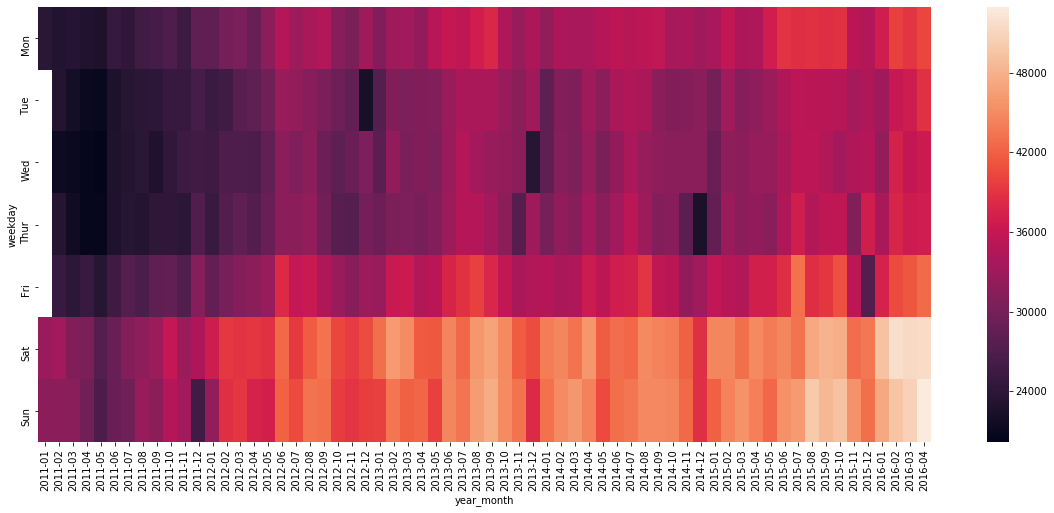

In [113]:
fig, ax = plt.subplots(figsize=(20, 8))
ax = sns.heatmap(df_total_agg_sales.groupby(["year_month", "weekday"])["unit_solds"].mean().unstack(level="year_month"))

ax.set_yticklabels(["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]);

#### Decomposition and Volume Sales Frequency

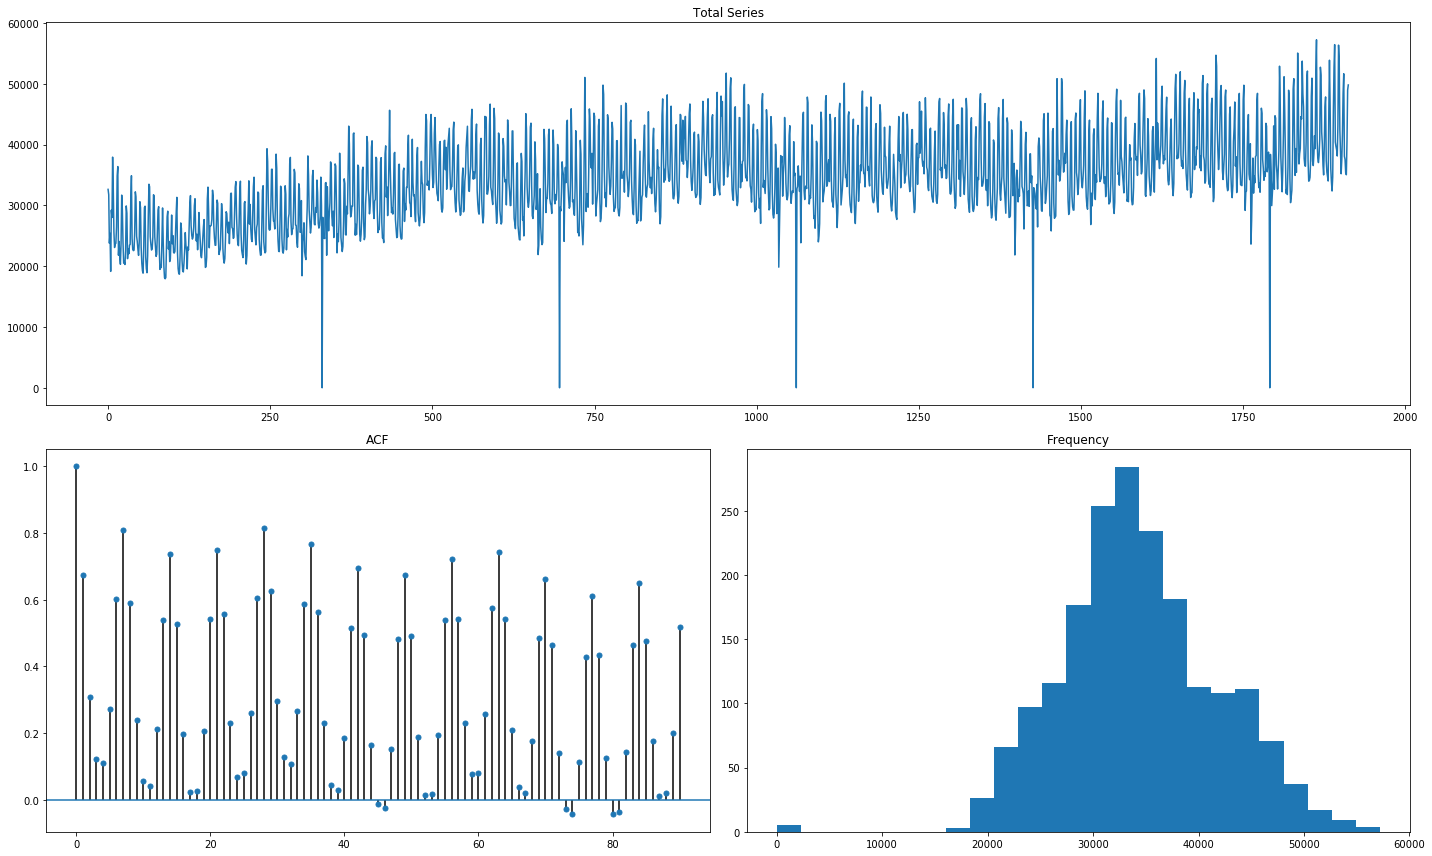

In [19]:
pm.tsdisplay(df_total_agg_sales["unit_solds"], lag_max=90, title="Total Series", show=True, figsize=(20, 12))

From above we see the ACF plot for our total series and frequency distribution, which is close to a normal distribution, an important assumption in many models, however, we need to assure that for our lower level series as well.

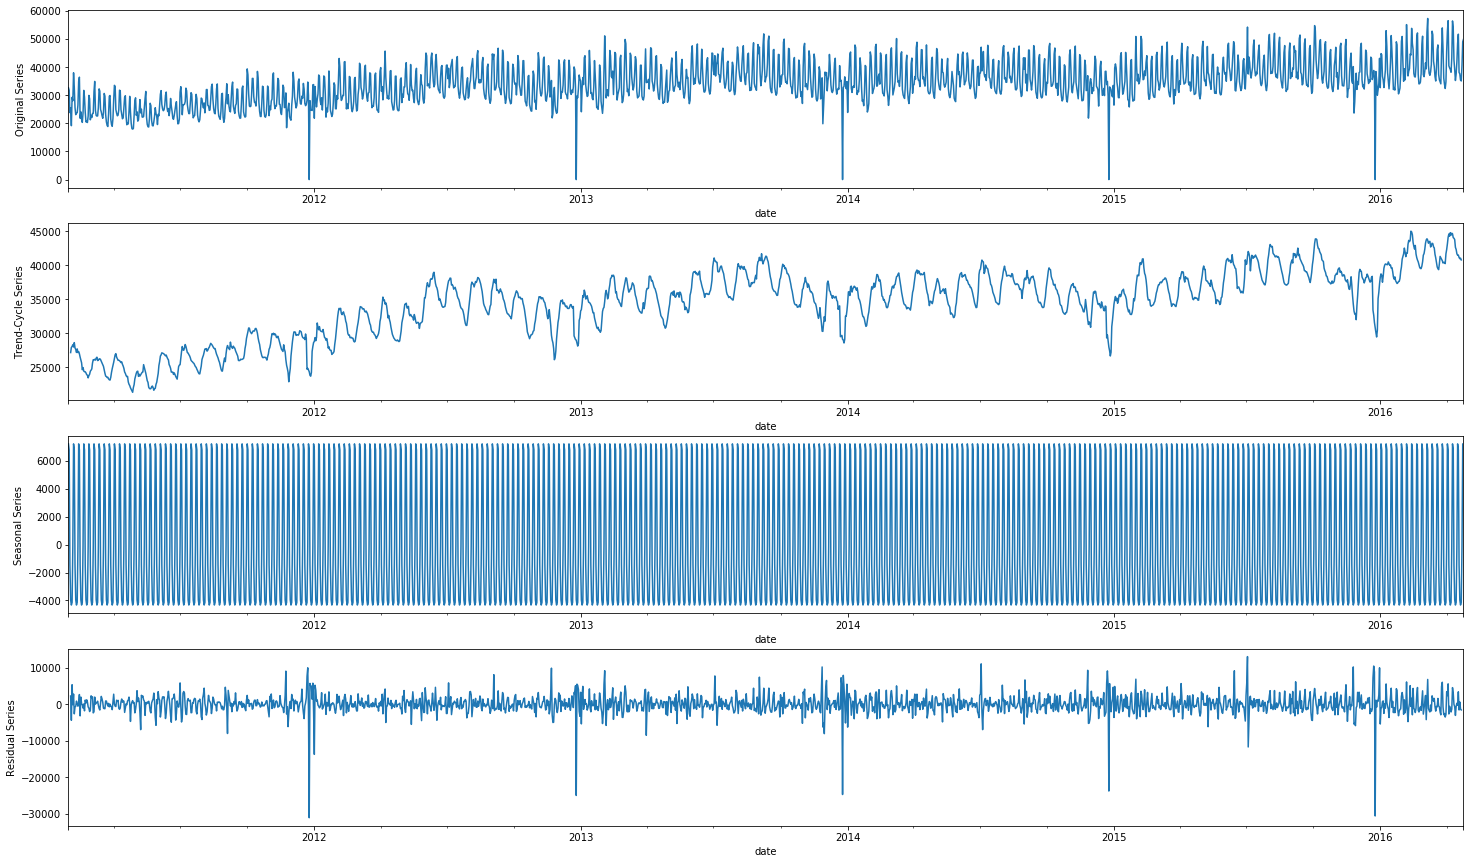

In [45]:
from visualize import plot_seasonal_decompose, tsplot

decomposed = plot_seasonal_decompose(df_total_agg_sales["unit_solds"])

We can note a few interesting things we have already mentioned:
 - the trend-cycle components shows a monthly cycle / seasonal period. This is a strong indicative that our data have multiple seasonalities.
 - Also, trend is again showing a unit sales increasing over time.

### Sales by State

Now we are going to dig a little deeper in our hierarchical structure and explore sales by states, distributions and other interesting plots that can help up in building a model to predict sales.

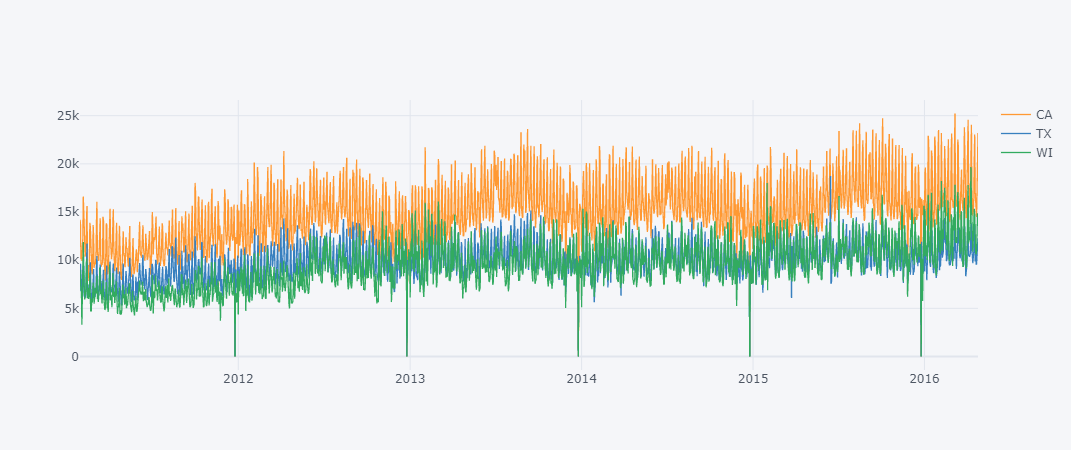

In [118]:
df_state_grp = df_sales_cal.groupby(["state_id", "date"])

df_states_sales = df_state_grp["unit_solds"].sum()
df_states_sales_pivoted = df_states_sales.unstack(level="state_id")
df_states_sales_pivoted.iplot()

Doing total sales by state shows us how they differ in their pattern sales over the years. To begin, Texas (TX) does not have a strong trend and sales were more stable in the period analyzed. Of course, all of this is difficult to see in the raw plot only, let's see the moving average plots as well.

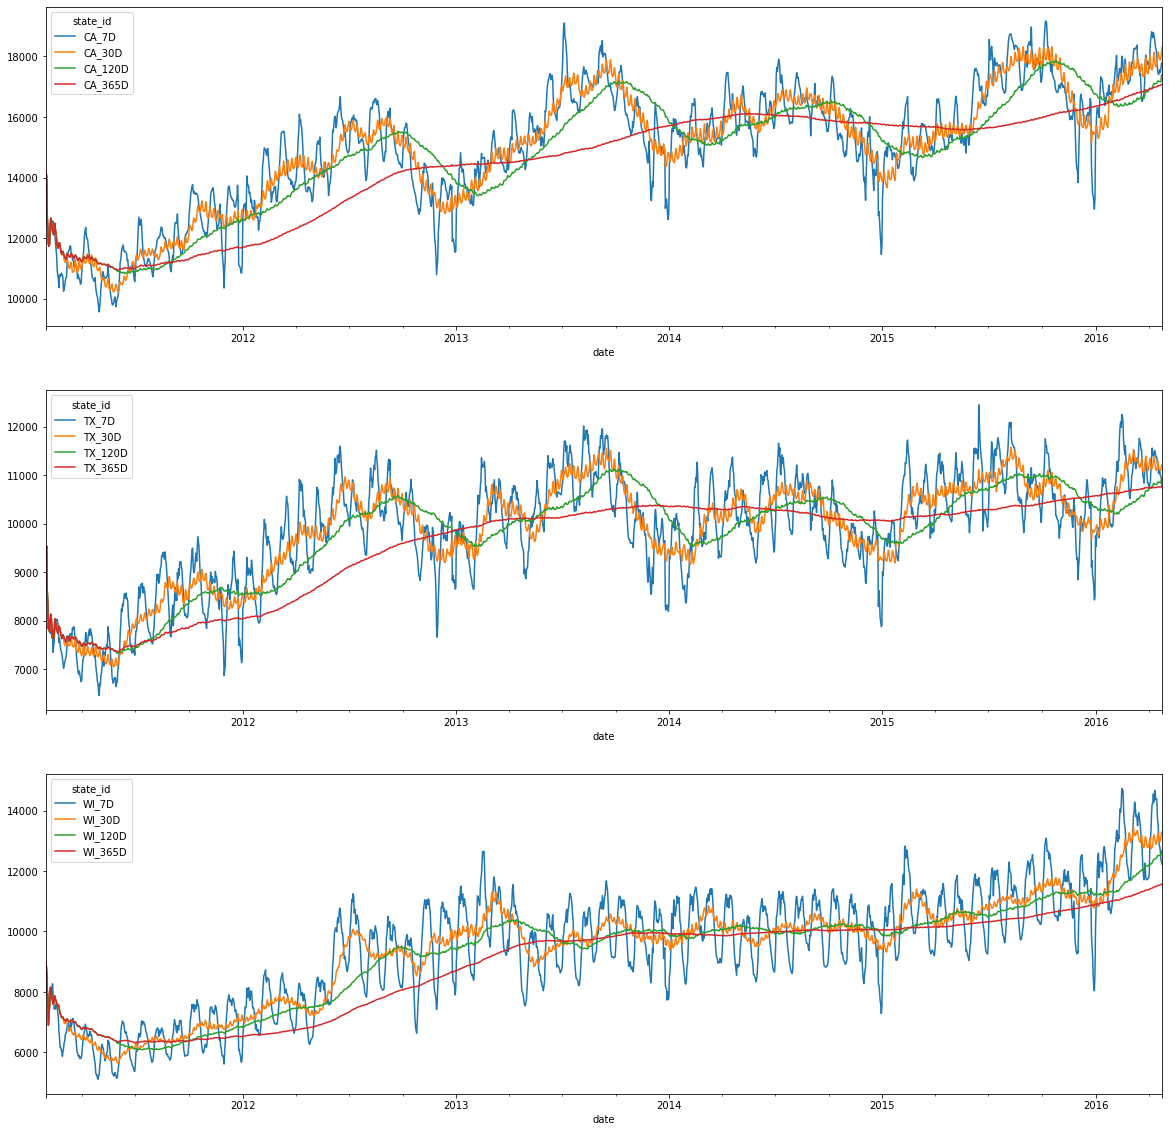

In [132]:
def roll_pivoted_df(rollings=None):
    df_rolls = []
    for roll in rollings:
        df_rolls.append(df_states_sales_pivoted.rolling(roll).mean().rename(columns=lambda x: f"{x}_{roll}"))
    
    return pd.concat(df_rolls, axis=1)


df_state_rolling_avg = roll_pivoted_df(rollings=["7D", "30D", "120D", "365D"])

def return_cols_state(state):
    return [col for col in df_state_rolling_avg.columns if state in col]

fig, axes = plt.subplots(3, 1, figsize=(20, 20))

df_state_rolling_avg[return_cols_state("CA")].plot(ax=axes[0])
df_state_rolling_avg[return_cols_state("TX")].plot(ax=axes[1])
df_state_rolling_avg[return_cols_state("WI")].plot(ax=axes[2])

- TX had a trend of increasing sales up to 2013, then this trend remained stable.
- By the 120D line, we see that both CA and TX states present a within year cycle, where towards the end of the year we get an average increase in sales.